In [1]:
from utils import *
from matplotlib import pyplot as plt
import numpy as np
from numpy.fft import fft, fftshift, ifft, ifftshift

In [2]:
# generate object
setup = {
    'N': 8192,
    'L': 2e-3, # 1mm
    'lambda_0': 650e-9, # 650nm, red light
    'f1': 45e-3, # 45mm
    'f2': 25e-3, # 25mm
    'A': 5e-3, # 5mm
    'plot': False
}
n = setup['N']
sample_size = 4096
sample = test_sum(sample_size, a=255, n_cycles=128, sigma=0.1)
object = np.zeros(n, dtype=np.complex128)
object = center_splice(object, sample)

In [3]:
n_leds = 8
n_samples_led = 5000
size_led = 223e-3
spacing = 4e-3
led_fwhm = 0.1e-3

# compute coordinates for aperture field
kx = np.fft.fftfreq(setup['N'], d=setup['L']/setup['N'])
kx = np.fft.fftshift(kx)*setup['lambda_0']*setup['f1']

A_samples = int((setup['A'] / (np.max(kx) - np.min(kx))) * setup['N'])


In [4]:
# generate array of images

images = []
for i, (index, x) in enumerate(led_array(32, n_samples_led, size_led, spacing, led_fwhm)):
    # compute illumination, propagate to object plane
    x_out, _ = propagate_fft(x)
    x_field = np.zeros(n, dtype=np.complex128)
    x_field = center_splice(x_field, x_out)
    
    # compute object field
    object_field = x_field * object
    
    # image object
    img = image(object_field, setup)
    img_amp = np.abs(img) # output image amplitude, same as sqrt(intensity(image(object, setup))
    images.append((index, img))

img_len = len(images[0][1])

# calculate offset due to plane wave
offset = int((np.argmax(fftshift(fft(fftshift(images[1][1])))) - len(images[1][1])//2))

# generate high resolution base object
hr_len = n
old_coords = np.arange(img_len) # coordinates of output image
interp_coords = np.linspace(0,img_len, hr_len) # coordinates of interpolated image
# hr_object = np.interp(interp_coords, old_coords, images[0][1], int(hr_len/img_len)) # sqrt of intensity of output, interpolated
hr_object = np.zeros(hr_len, dtype=np.complex128)
hr_spectrum = fftshift(fft(fftshift(hr_object)))

object_rescaled = object_field / np.max(np.abs(object_field))

In [5]:
output = reconstruct_gs(images, offset, hr_len)
output_img = ifftshift(ifft(ifftshift(output)))

<Figure size 2000x300 with 0 Axes>

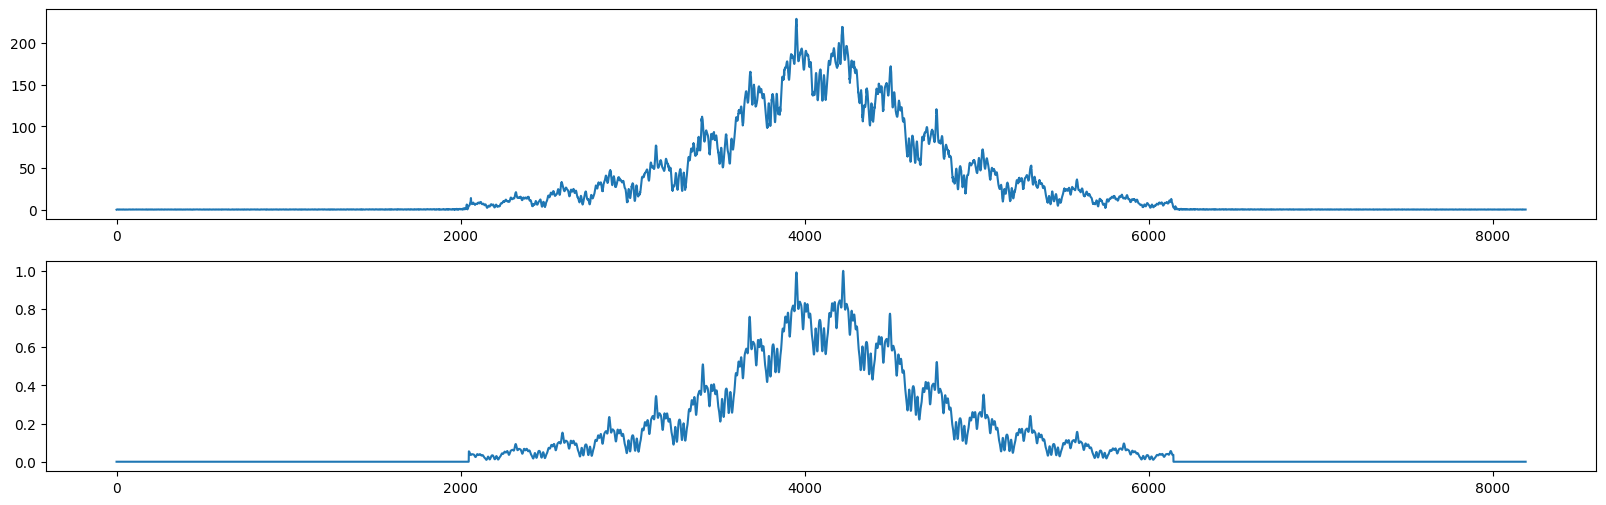

In [6]:
plt.figure(figsize=(20,3))
_, axs = plt.subplots(2,1, figsize=(20,6))
axs[0].plot(np.abs((output_img)))
# axs[0].set_xlim(40000, 60000)
axs[1].plot(np.abs(object_rescaled))


In [7]:
print(mse(np.abs(normalize(object[2048:6144])), np.abs(normalize(output_img[2048:6144]))))

0.026805604992194115
